# io

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [40]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)

In [41]:
import skimage 
raw = skimage.io.imread("../images/raw.jpeg")

In [42]:
def show(image,gray=True):
    if gray:
        sns.heatmap(image,cmap='gray',rasterized=True)
#         plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image,rasterized=True)

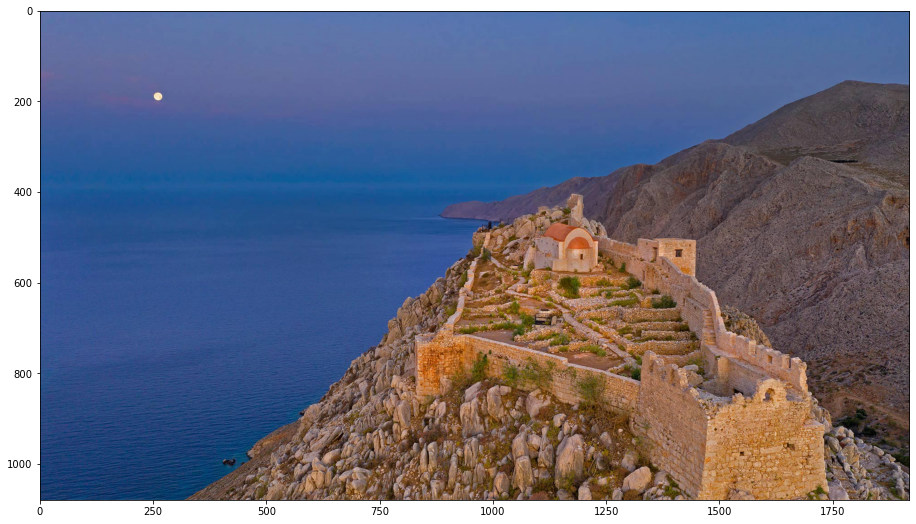

In [43]:
show(raw,gray=False)
plt.savefig("../figures/raw.pdf")

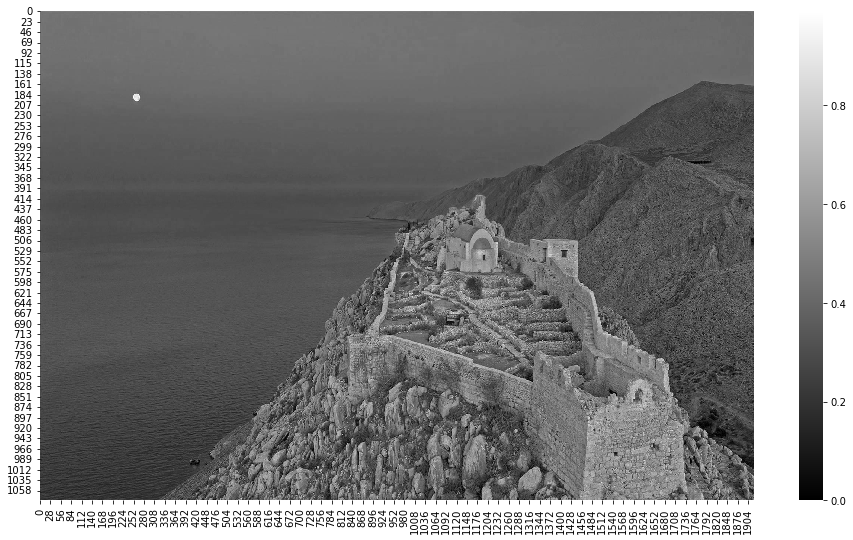

In [44]:
gray = skimage.color.rgb2gray(raw)
show(gray)

# edge_detect

## Sobel

In [45]:
import scipy.ndimage as ndi
import pandas as pd

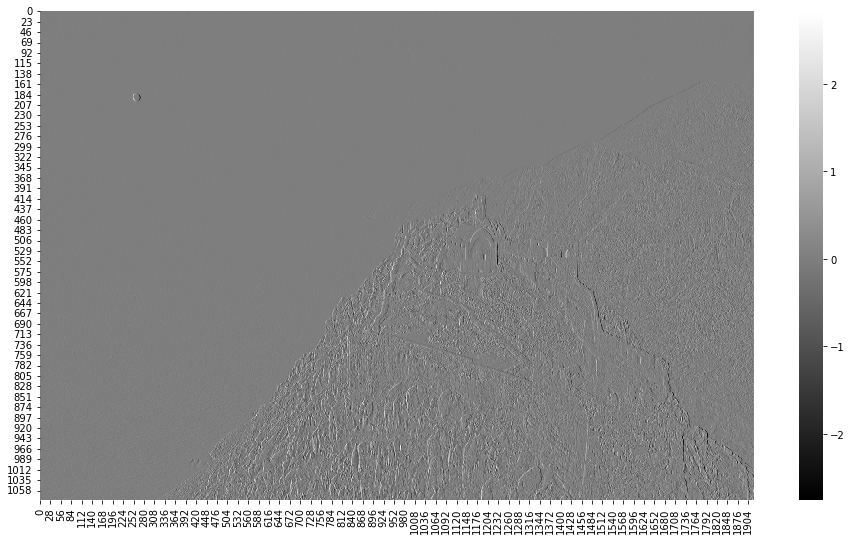

In [46]:
kernel_x = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]])
x_sharpen = ndi.convolve(gray, kernel_x)
show(x_sharpen)

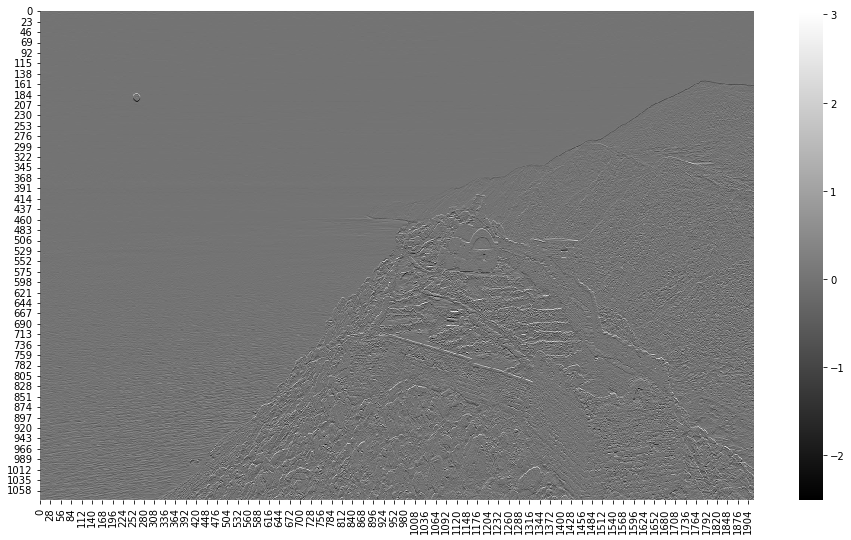

In [47]:
kernel_y = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]])
y_sharpen = ndi.convolve(gray,kernel_y)
show(y_sharpen)

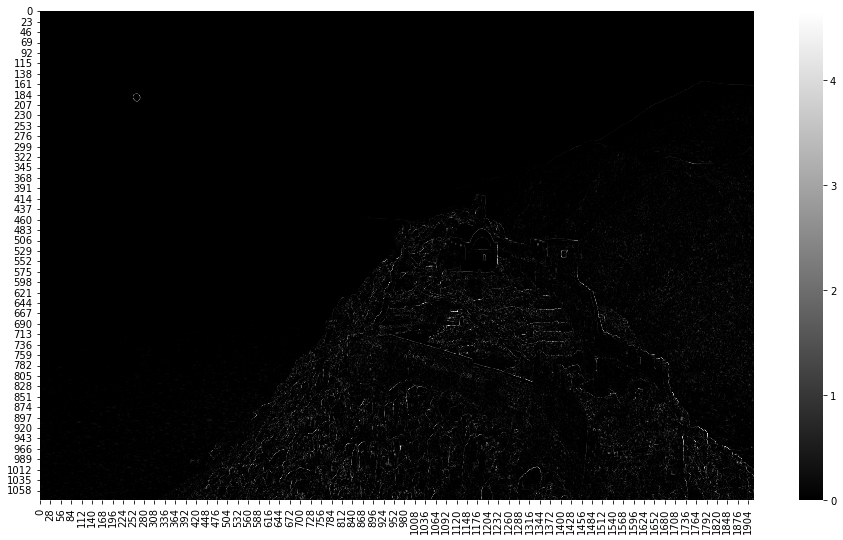

In [48]:
show((x_sharpen ** 2 + y_sharpen ** 2) ** 1/2)

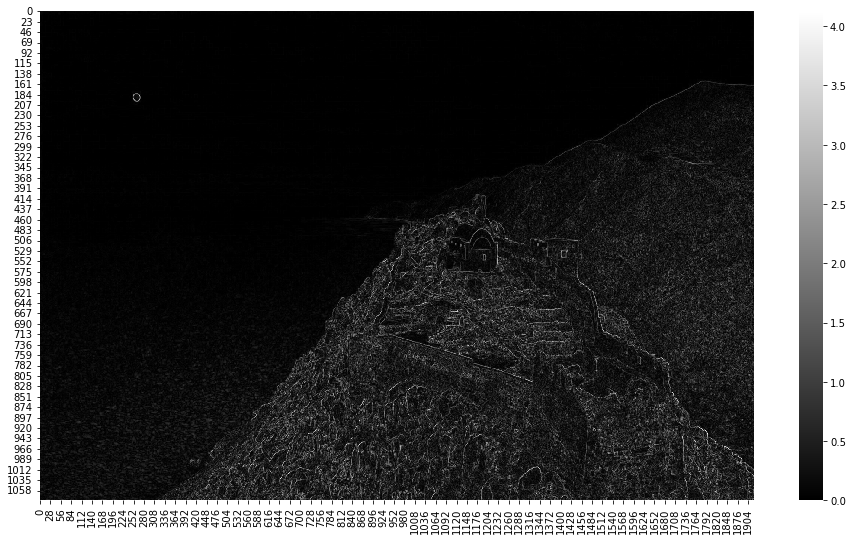

In [49]:
sobel_abs = abs(x_sharpen) + abs(y_sharpen)
show(sobel_abs)

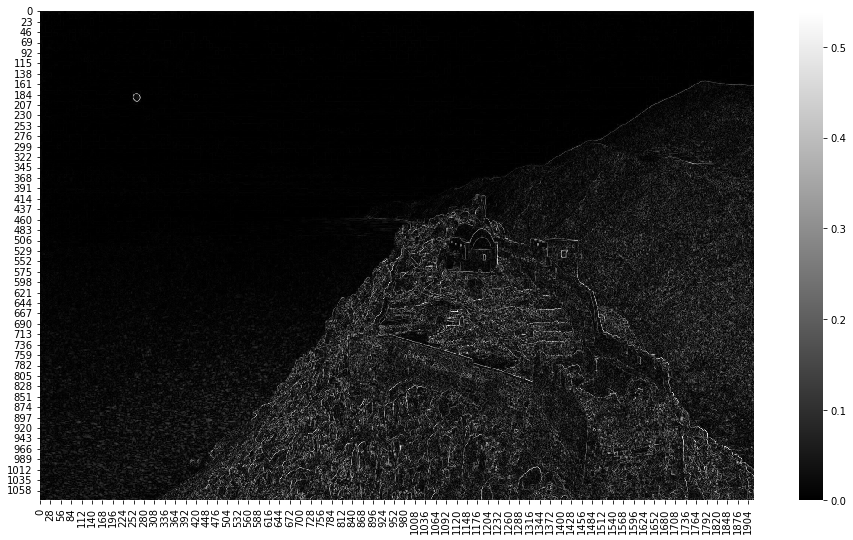

In [50]:
sobel = skimage.filters.sobel(gray)
show(sobel)

<AxesSubplot:ylabel='Density'>

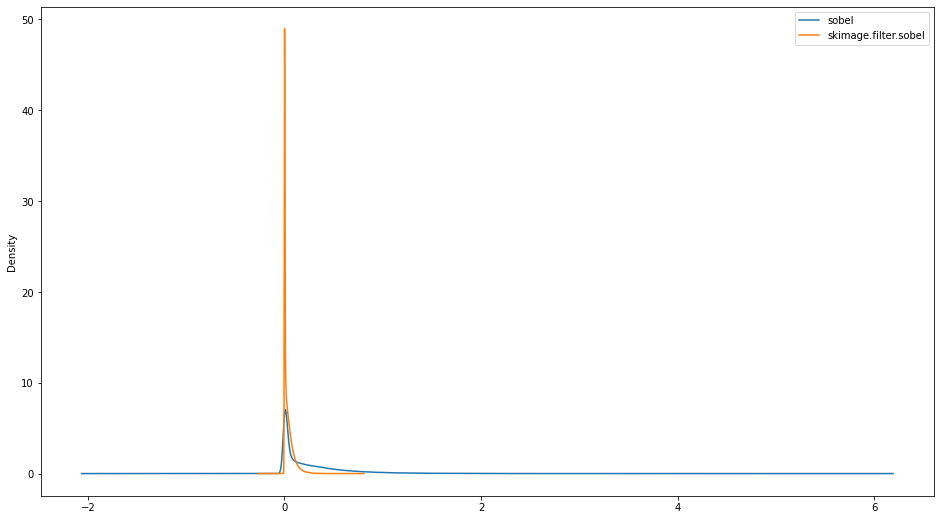

In [51]:
pd.DataFrame({"sobel": sobel_abs.flatten(), "skimage.filter.sobel": sobel.flatten()}).plot(kind="kde")

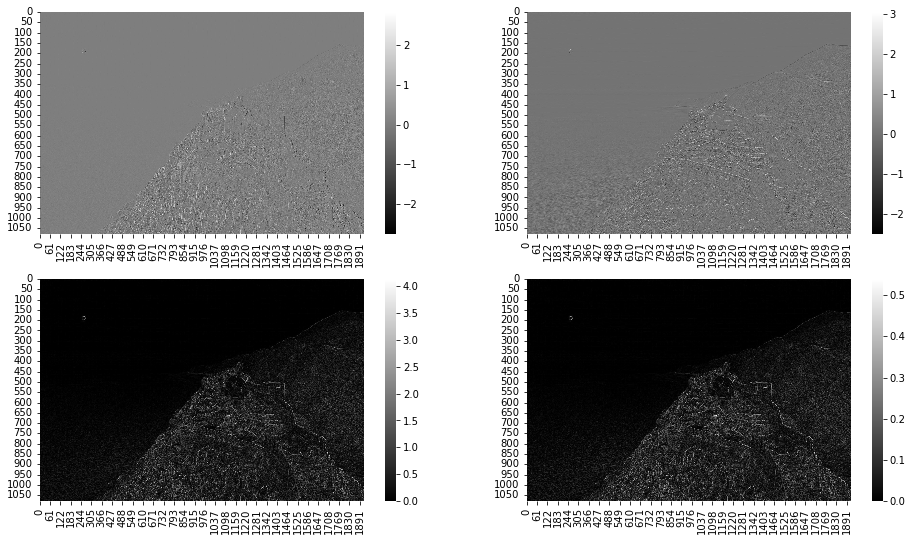

In [52]:
plt.subplot(2,2,1)
show(x_sharpen)

plt.subplot(2,2,2)
show(y_sharpen)

plt.subplot(2,2,3)
show(sobel_abs)

plt.subplot(2,2,4)
show(sobel)

plt.savefig("../figures/sobel.pdf",bbox_inches="tight")

## Prewitt

$$
    G'x = \begin{bmatrix}
        -1 & 0 & 1 \\
        -1 & 0 & 1 \\
        -1 & 0 & 1
    \end{bmatrix}
    \circledast A 
$$

$$
    G'y = \begin{bmatrix}
        1 & 1 & 1 \\
        0 & 0 & 0 \\
        -1 & -1 & -1
    \end{bmatrix}
    \circledast A 
$$

$$
    A'(x,y) = |G'_x(x,y)| + |G'_y(x,y)| 
$$

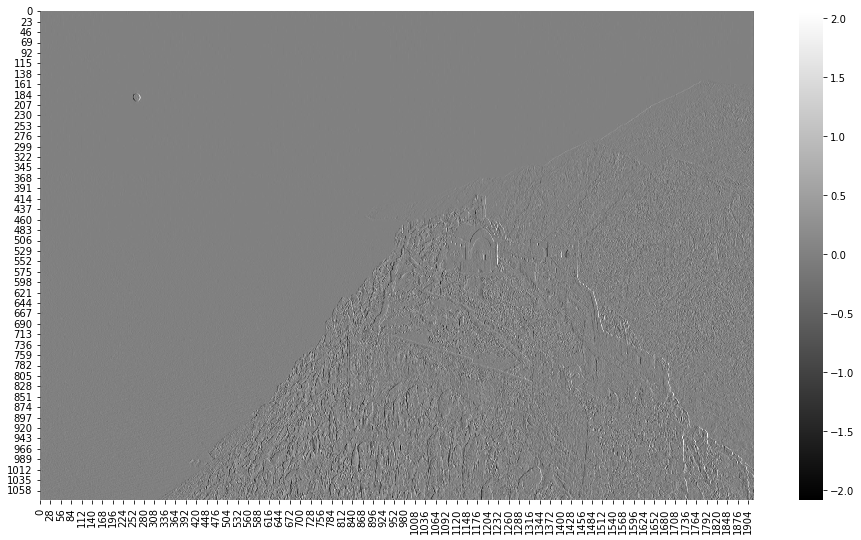

In [53]:
kernel_x = np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]])
x_sharpen = ndi.convolve(gray, kernel_x)
show(x_sharpen)

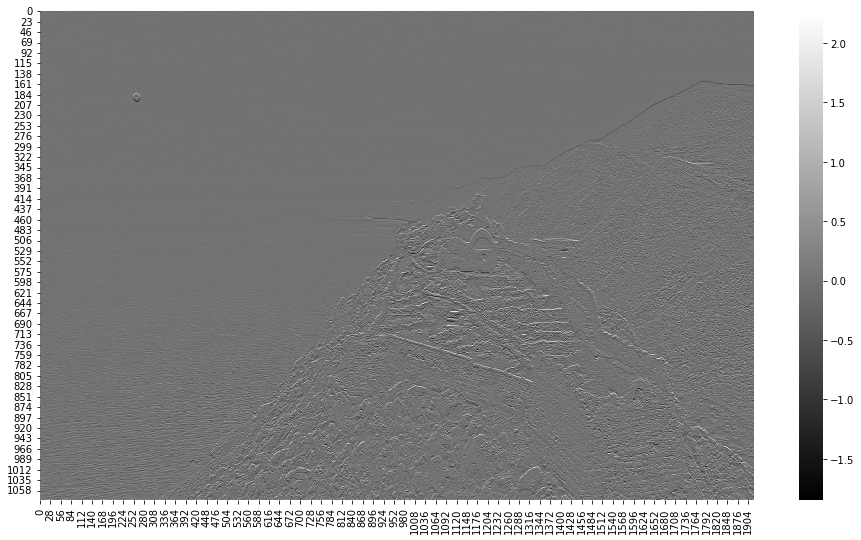

In [54]:
kernel_y = np.array([
    [1,1,1],
    [0,0,0],
    [-1,-1,-1]])
y_sharpen = ndi.convolve(gray,kernel_y)
show(y_sharpen)

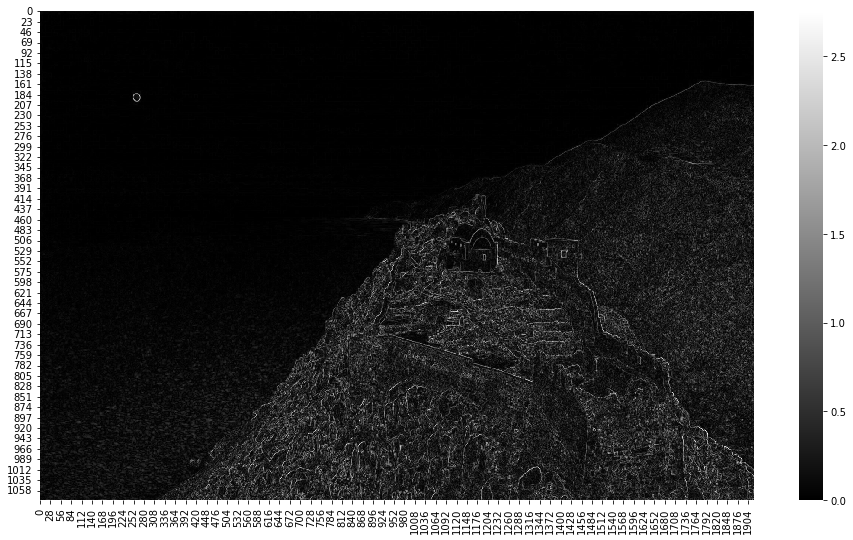

In [55]:
new_abs = abs(x_sharpen) + abs(y_sharpen)
show(new_abs)

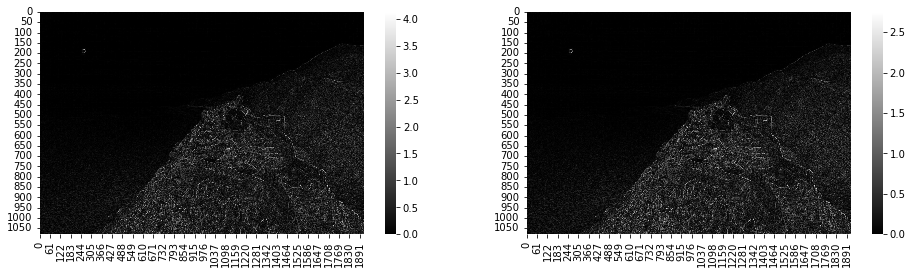

In [56]:
plt.subplot(2,2,1)
show(sobel_abs)

plt.subplot(2,2,2)
show(new_abs)

plt.savefig("../figures/sobel_vs_prewitt.pdf",bbox_inches="tight")

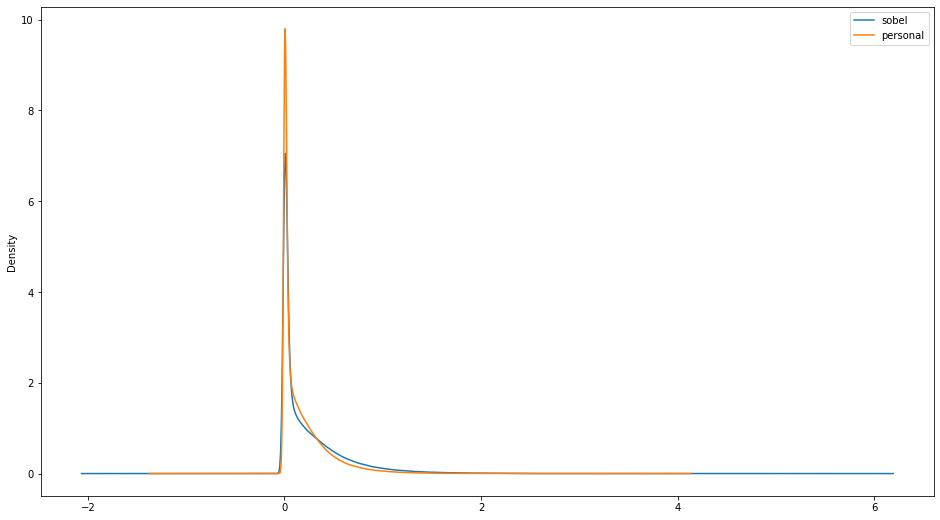

In [57]:
pd.DataFrame({"sobel": sobel_abs.flatten(), "personal": new_abs.flatten()}).plot(kind="kde")
plt.savefig("../figures/sobel_compare.pdf")

# Hough 线检测

In [58]:
import matplotlib

In [59]:
edge = skimage.feature.canny(gray)

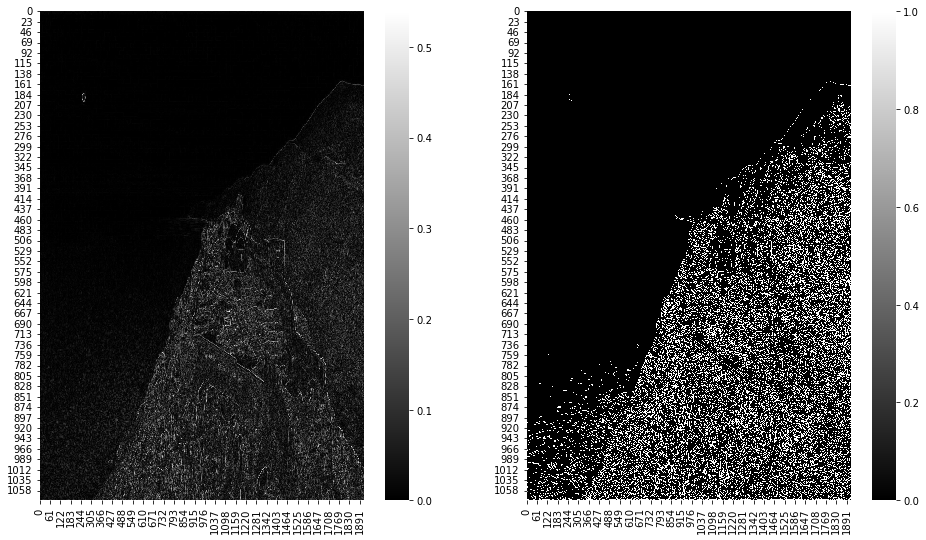

In [60]:
plt.subplot(1,2,1)
show(sobel)
plt.subplot(1,2,2)
show(edge)

In [61]:
def display_houge_transform(edge):
    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    tested_angles = \
        np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = \
        skimage.transform.hough_line(gray, theta=tested_angles)
    
    # Generating figure 1
    fig, axes = plt.subplots(2,2)
    ax = axes.ravel()

    ax[0].imshow(edge, cmap=matplotlib.cm.gray)
    ax[0].set_title('caany edge detect')
    ax[0].set_axis_off()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
              np.rad2deg(theta[-1] + angle_step),
              d[-1] + d_step, d[0] - d_step]
    # ax[1].imshow(
    #     np.log(1 + h), 
    #     extent=bounds, 
    #     cmap=matplotlib.cm.gray, aspect=1 / 1.5)
    ax[1].imshow(
        np.log(1 + h),
        extent=bounds,
        cmap=matplotlib.cm.gray)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(edge, cmap=matplotlib.cm.gray)
    ax[2].set_ylim((gray.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    for _, angle, dist in \
            zip(*skimage.transform.hough_line_peaks(h, theta, d)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

    ax[3].set_axis_off()

    plt.tight_layout()


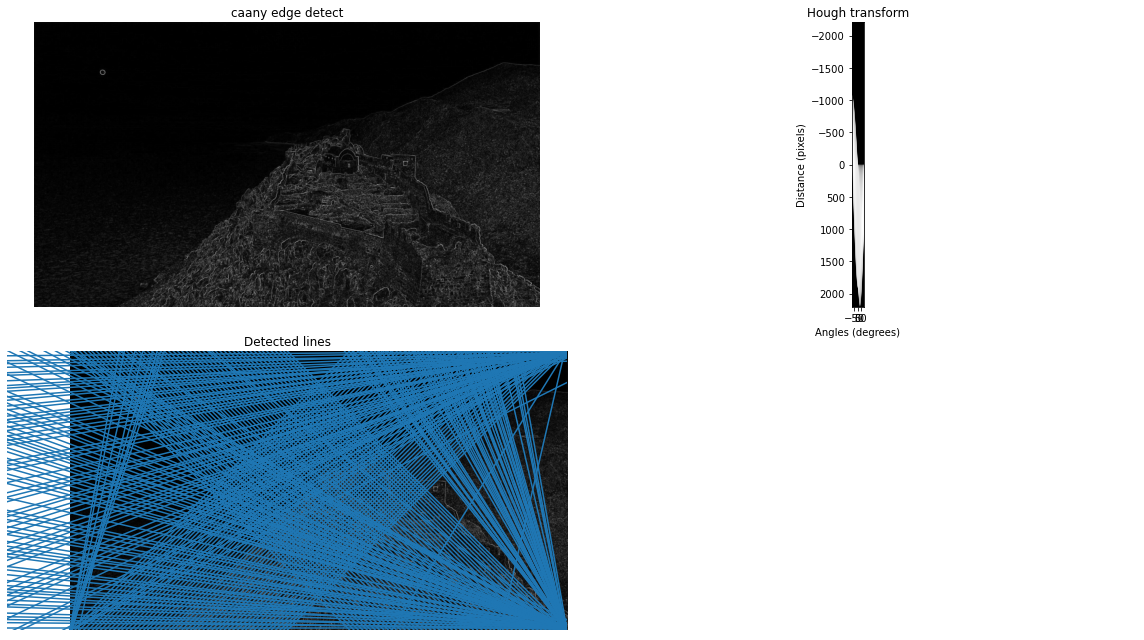

In [62]:
display_houge_transform(sobel)
plt.savefig("../figures/hough.pdf")

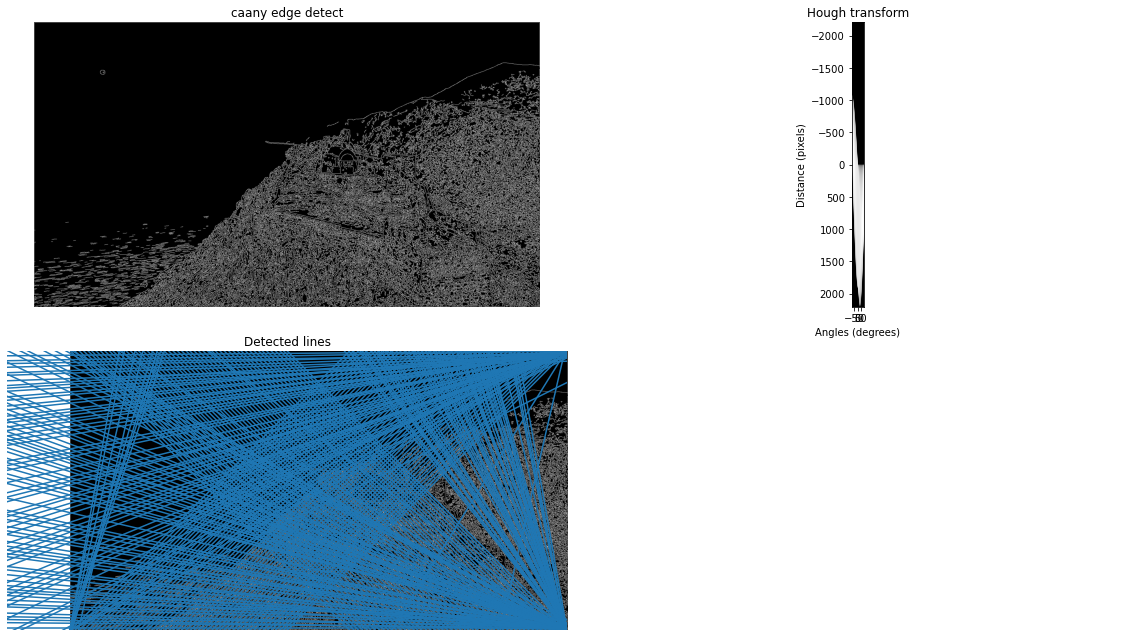

In [63]:
display_houge_transform(edge)

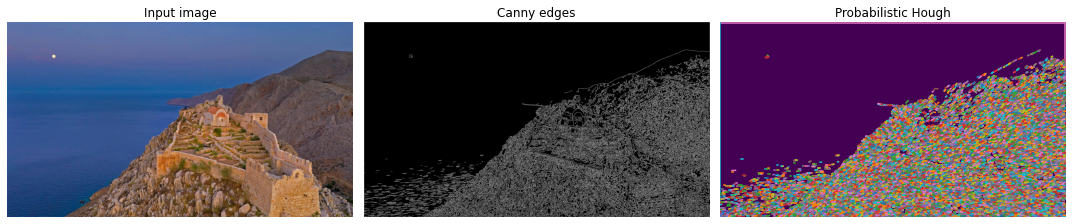

In [64]:

edge = skimage.feature.canny(gray)
lines = skimage.transform.probabilistic_hough_line(
    edge, 
    threshold=10, 
    line_length=5,
    line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()


ax[0].imshow(raw, cmap=matplotlib.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edge, cmap=matplotlib.cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edge * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, raw.shape[1]))
ax[2].set_ylim((raw.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.savefig("../figures/probabilistic_hough.pdf")

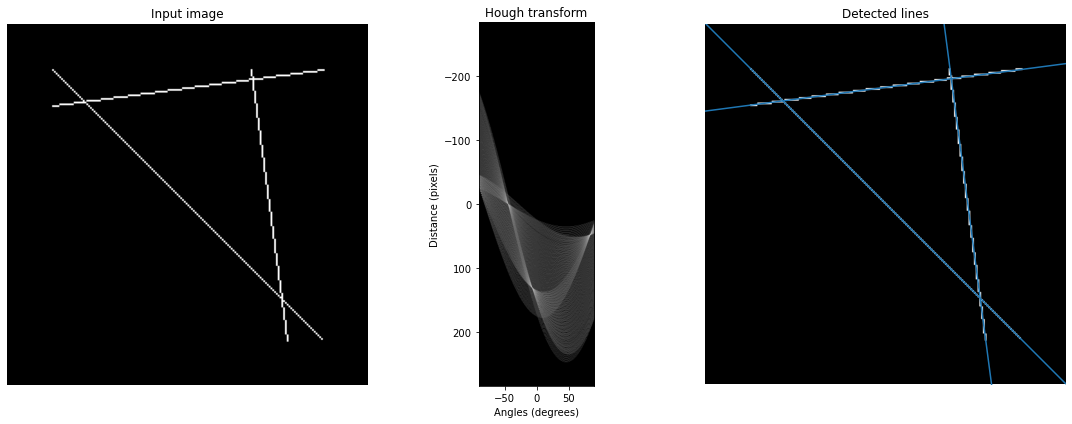

In [65]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm


# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx, idx] = 255
image[line(45, 25, 25, 175)] = 255
image[line(25, 135, 175, 155)] = 255

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.savefig("../figures/hough_example.pdf")
plt.show()

# image segmentation

<AxesSubplot:ylabel='Density'>

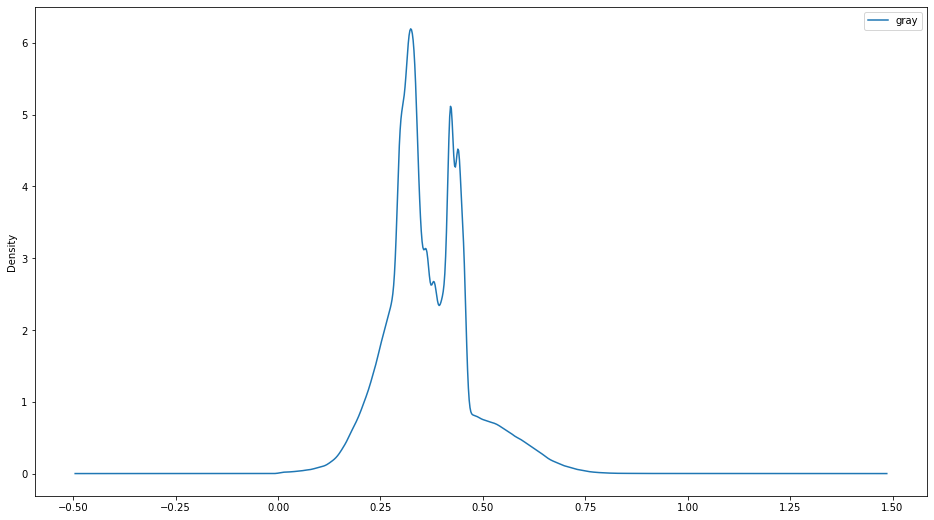

In [66]:
pd.DataFrame({"gray": gray.flatten()}).plot(kind="kde")

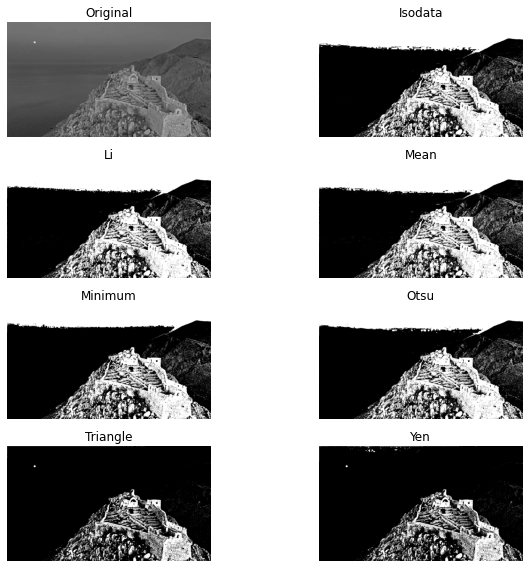

In [67]:
fig, ax = skimage.filters.try_all_threshold(gray, figsize=(10, 8), verbose=False)

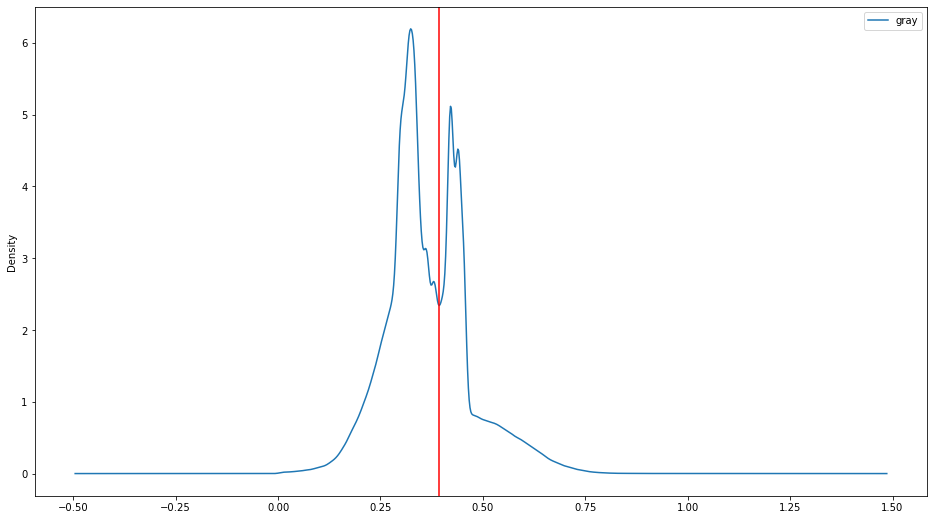

In [68]:
from skimage.filters import threshold_minimum
thresh_min = skimage.filters.threshold_minimum(gray)

pd.DataFrame({"gray": gray.flatten()}).plot(kind="kde")
plt.axvline(thresh_min, color='r')
plt.savefig("../figures/threshold.pdf")

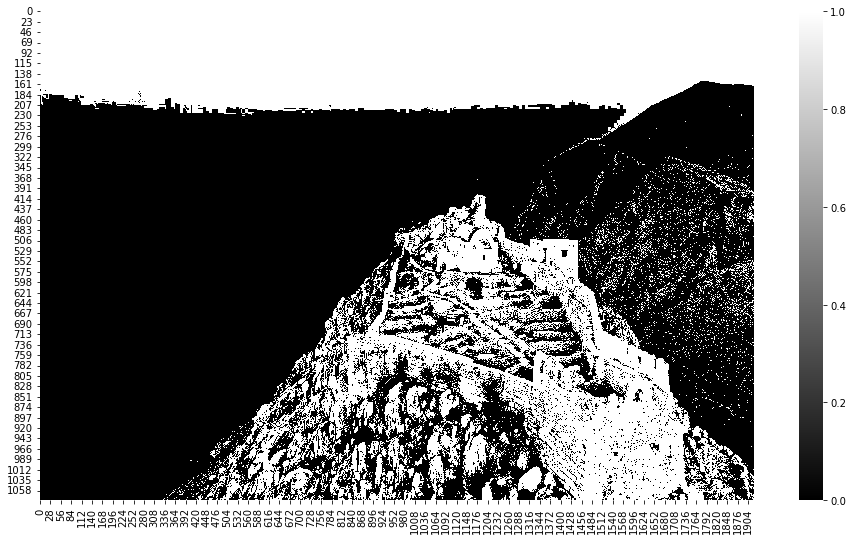

In [69]:
bin_image = gray.copy()
bin_image[bin_image > thresh_min] = 1
bin_image[bin_image < thresh_min] = 0
show(bin_image)
plt.savefig("../figures/bin.pdf")